<a href="https://colab.research.google.com/github/logicalschema/data620/blob/main/Week10/Data_620_Week_10_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 620 Week 10 Assignment

[Github Link](https://github.com/logicalschema/data620/tree/main/Week10/)

[YouTube Video](https://youtu.be/o5gaLpyYyuk)  

<img src=https://github.com/logicalschema/data620/raw/main/Week10/data/spam_ham.jpg width="150">

## Assignment
It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

This assignment is due end of day on 4/25.

NOTE: This is a two week assignment.




# Data
The data used for this assignment is from the Apache Software Foundation's SpamAssassin Project: https://spamassassin.apache.org/old/publiccorpus/ 

Emails are files that have already been classified as spam or ham.

The emails have been organized into compressed tar files and are available in the Github repository. Below are the specific links: 

https://github.com/logicalschema/data620/raw/main/Week10/data/ham.tar.gz 

https://github.com/logicalschema/data620/raw/main/Week10/data/spam.tar.g


## Download

The following code downloads the compressed tar files and unzips them in the notebook.

In [79]:
!wget https://github.com/logicalschema/data620/raw/main/Week10/data/ham.tar.gz
!wget https://github.com/logicalschema/data620/raw/main/Week10/data/spam.tar.gz
!tar -xzf ham.tar.gz
!tar -xzf spam.tar.gz


--2021-04-24 22:12:23--  https://github.com/logicalschema/data620/raw/main/Week10/data/ham.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/logicalschema/data620/main/Week10/data/ham.tar.gz [following]
--2021-04-24 22:12:23--  https://raw.githubusercontent.com/logicalschema/data620/main/Week10/data/ham.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5054556 (4.8M) [application/octet-stream]
Saving to: ‘ham.tar.gz.1’

ham.tar.gz.1        100%[===================>]   4.82M  --.-KB/s    in 0.1s    

2021-04-24 22:12:24 (33.9 MB/s) - ‘ham.tar.gz.1’ saved [5054556/5054556]

--2021-04-24 

# Setup

This assignment will use mainly the `nltk` and `sklearn` libraries. Additional libraries are used to check spelling an perform operations on text.

## Libraries

In [80]:
import os
import pandas as pd
import sys
import string
import numpy
import re 
from email.parser import BytesParser, Parser
from email.policy import default

from html import unescape

# NLTK
# Used for various language features
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.classify import apply_features
from nltk.collocations import *
from collections import Counter


# Used for splitting the data into three groups devtest, test, and training
from sklearn.model_selection import train_test_split

# These libraries will use the sklean library for modeling and checking for accuracy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [81]:
# Downloads for use in sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [82]:
# Downloads for use in detecting stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
# Used for checking for misspellings
!pip install pyspellchecker
from spellchecker import SpellChecker

spell = SpellChecker()

## Importing the Data

The functions below import the uncompressed files into a dataframe.

In [84]:
# Assumes that ham and spam have been uncompressed and reside in the same directory as this Python file

HAM = 'ham'
SPAM = 'spam'
NEWLINE = '\n'

SOURCES = [
	('ham/', HAM),
	('spam/', SPAM)
]

SKIP_FILES = {'cmds'}

# Get the Total number of files
TOTAL_FILES = 0

files = os.listdir("ham/")
TOTAL_FILES = len(files) 
files = os.listdir("spam/")
TOTAL_FILES += len(files)


In [85]:
# Displays the processing of the text emails
def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

# Reads the files in the path
def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    with open(file_path, "rb") as f:
                    	msg = BytesParser(policy=default).parse(f)
                    yield file_path, msg

def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, email) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, TOTAL_FILES - 50, 50)
        rows.append({'email': email, 'class': classification})
        index.append(file_name)
   
    data_frame = pd.DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = pd.DataFrame({'email': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(numpy.random.permutation(data.index))
    return data


def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

# message must be email.ByteParser 
def email_items(message):
	fromEmail = str(message['from']) 
	toEmail = str(message['to'])
	subjectEmail = str(message['subject'])
	contentType = message.get_content_type()
 
	content = ""

	if message.is_multipart():
		for payload in message.get_payload():
			content = content + str(payload.get_payload())
	else:
		content = message.get_payload()
  
	content = html_to_plain_text(content)

	return fromEmail, toEmail, subjectEmail, content, contentType


In [86]:
# Loads all of the spam and ham email files into a DataFrame called data
data = load_data()

Percent: [##################################################] 100%

In [87]:
# Add additional columns to the data DataFrame: From, To, Subject, Content, and ContenType
data['From'], data['To'], data['Subject'], data['Content'], data['ContentType'] = zip(*data['email'].apply(lambda x:
	email_items(x)
	))

Here is a snippet of the new dataframe. There is an identifier for the file, `email`, `class`, `From`, `To`, `Subject`, `Content`, and `ContentType`. 

In [88]:
# Snippet of the new DataFrame
data.head(5)

,email,class,From,To,Subject,Content,ContentType
ham/00232.24e7a66753dfa7f93df6a2c5125e0cb3,"[Return-Path, Delivered-To, Received, Received...",ham,SoloCDM <deedsmis@aculink.net>,"""Hunt, Bryan"" <B.Hunt@emuse-tech.com>",[ILUG] Re: removing lilo,"""Hunt, Bryan"" stated the following:\n>\n> choo...",text/plain
spam/00808.c072069806eb82f9aaf8d21d39789ea6,"[Received, Message-Id, Received, Date, From, S...",spam,Callie <callie@DEALSWEEPS.IREAYE.NET>,gibbs@MIDRANGE.COM,Discover� Platinum Clear Card New Clear Design!,\n*Click HYPERLINK here to see information ab...,text/html
ham/01380.0a97683490023a8f59c230f5057d15bd,"[Return-Path, Delivered-To, Received, Received...",ham,Rick Beebe <richard.beebe@yale.edu>,Don Newcomer <newcomer@dickinson.edu>,Re: [SAtalk] Tru64 compile of SA,Don Newcomer wrote:\n> I'm a new user (or abou...,text/plain
ham/01599.30e5cb62246ea4c06dbe1f8024ef9ffc,"[Return-Path, Delivered-To, Received, Received...",ham,Whit Blauvelt <whit@transpect.com>,razor-users@example.sourceforge.net,"[Razor-users] ""No razor servers available at t...","I'm getting ""no servers available"" about half ...",text/plain
ham/00007.d24e99a602ee7fb442714c0d448cd08e,"[Return-Path, Received, Received, Received, Re...",ham,Fax2Mail <R-1-270241-5399979-2-24365-DE1-3A9F1...,Zzzzz@gmx.de,F2M - Ihre kostenlose Faxnummer - Newsletter,Bitte beachten Sie die Angebote unserer Werb...,text/html


## Initial View of the Data

Here is an initial view of the dataframe. There are a total of 6,047 files.

In [89]:
data.count()


email          6047
class          6047
From           6047
To             6047
Subject        6047
Content        6047
ContentType    6047
dtype: int64

Below are the numbers of ham and spam emails.


In [90]:
print("There are a total of " + str(len(data[data['class'] == 'spam'].index)) + " spam emails.")
print("There are a total of " + str(len(data[data['class'] == 'ham'].index)) + " ham emails.")
print(TOTAL_FILES)

There are a total of 1897 spam emails.
There are a total of 4150 ham emails.
6047


## Splitting the Data
The following code splits the data for the NLTK Naïve Bayes analysis with views of the train and test dataframes.

In [91]:
# Split the original data into two groups train and test with a 80/20 ratio and stratify based on class [spam, ham]
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data[['class']])

In [92]:
train.count()

email          4837
class          4837
From           4837
To             4837
Subject        4837
Content        4837
ContentType    4837
dtype: int64

In [93]:
test.count()

email          1210
class          1210
From           1210
To             1210
Subject        1210
Content        1210
ContentType    1210
dtype: int64

# Functions for Processing

The functions below are used for producing features to be used in the NLTK setup.

In [94]:
# Returns a list of the words from the text. 
# Removes punctuation, lowercases the words, and only returns words greater than 3 characters
def list_words(text):
  words = []

  # Remove punctuation from the text
  temp = text.translate(str.maketrans('', '', string.punctuation))
  words_tmp = temp.lower().split()
  for w in words_tmp:
    if w not in words and len(w) > 3:
      if w not in stop_words:
        words.append(w)
  return words

# Returns a count of the misspellings in the text (using list_words)
def misspellings(text):
  temp = list_words(text)
  misspelled = spell.unknown(temp)

  return len(misspelled)

# Returns the domain of the text
# Ex: Sung Lee <slee@sunysb.edu> would return sunysb.edu
def domain(text):
  temp = text.split('@')
  if len(temp) > 1:
    domainname = temp[1].replace('>', '')
  else:
    domainname = ' '
  return {'domainname': domainname}



In [95]:
# Function tokenizer
# Tokenizes a text variable. Converts words to lowercase and removes stop words
def quickTokenizer(textVar):
  tokens = word_tokenize(textVar)

  # Lowercase the tokens
  tokens_l = [w.lower() for w in tokens if w.isalpha()]

  filtered = []

  for w in tokens_l:
    if w not in stop_words:
      filtered.append(w)

  return filtered



# Analysis
This section looks at some of the features that will be pulled from the data.

## Word Frequency in Subjects and Content
This code pulls the top spam words from the subjects of the training email set.

In [96]:
train_subjects = ""
for index, row in train[train['class'] == 'spam'].iterrows():
  train_subjects = train_subjects + row['Subject']

corpusSpamSubjects = quickTokenizer(train_subjects)
freqtrainSpamSubjects = FreqDist(corpusSpamSubjects)

topSpamSubjectWords = pd.DataFrame(freqtrainSpamSubjects.most_common(100),columns=['Word','Frequency'])
topSpamSubjectWords.head(100)

,Word,Frequency
0,free,94
1,mortgage,43
2,money,38
3,ilug,37
4,life,34
...,...,...
95,price,8
96,men,8
97,never,8
98,interest,8


This code pulls the top subject words from the ham training emails. I was not familiar with term `ilug` ("I love you guys").

In [97]:
train_subjects = ""
for index, row in train[train['class'] == 'ham'].iterrows():
  train_subjects = train_subjects + row['Subject']

corpusHamSubjects = quickTokenizer(train_subjects)
freqtrainHamSubjects = FreqDist(corpusHamSubjects)

topHamSubjectWords = pd.DataFrame(freqtrainHamSubjects.most_common(100),columns=['Word','Frequency'])
topHamSubjectWords.head(100)

,Word,Frequency
0,ilug,440
1,satalk,143
2,spambayes,110
3,zzzzteana,107
4,ouch,103
...,...,...
95,another,16
96,question,16
97,good,16
98,forged,16


This code sets up the feature for counting the top spam subject words using the difference of the top subject ham and spam words found in the subject.

In [98]:
topspamsubjectwords = set(topSpamSubjectWords.head(100)['Word'].tolist())
b = set(topHamSubjectWords.head(100)['Word'].tolist())

topspamsubjectwords = topspamsubjectwords - b

def countSpamSubjectWords(text):
  count = 0
  corpus = quickTokenizer(text)
  freq = FreqDist(corpus)
  for key in freq.keys():
    if key in topspamsubjectwords:
      count = count + freq[key] 
  return count



This code looks for the top spam words in the content of the training data.

In [99]:
train_content = ""
for index, row in train[train['class'] == 'spam'].iterrows():
  train_content = train_content + row['Content']

corpusSpamContent = quickTokenizer(train_content)
freqtrainSpamContent = FreqDist(corpusSpamContent)

topSpamContentWords = pd.DataFrame(freqtrainSpamContent.most_common(200),columns=['Word','Frequency'])
topSpamContentWords.head(100)

,Word,Frequency
0,hyperlink,4026
1,http,2374
2,email,2179
3,free,1972
4,click,1515
...,...,...
95,visit,339
96,easy,338
97,made,337
98,dollars,335


## Sentiment Analysis
I had started this section wishing to look at the sentiment analysis of the data. Later, I would find that sentiment analysis was not helpful and retroactively removed this feature from the model. Sentiment analysis was expensive and I did not find it helpful for this assignment.

In [100]:
def sentimentAnalysis(text):
  sia = SentimentIntensityAnalyzer()
  temp = sia.polarity_scores(text)

  return temp

def sanitizeText(text):
  words = []

  # Remove punctuation from the text
  temp = text.translate(str.maketrans('', '', string.punctuation))

  return temp.lower()


Sentiment analysis, in my opinion, is intensive. I added the `%%timeit` in the cell to show the time it takes.

In [101]:
%%timeit

# Sentiment Analysis 1
t = []
for index, row in train[train['class'] == 'spam'].iterrows():
  t.append(sentimentAnalysis(row['Content']))

u = []
for index, row in train[train['class'] == 'ham'].iterrows():
  u.append(sentimentAnalysis(row['Content']))


1 loop, best of 5: 1min 5s per loop


Here is a view of the sentiment analysis done on the emails.

In [102]:
# Sentiment Analysis 2
saspam = pd.DataFrame(t)
saspam.head(10)

,neg,neu,pos,compound
0,0.072,0.777,0.151,0.9487
1,0.129,0.695,0.176,0.8852
2,0.040,0.748,0.211,0.9632
3,0.000,1.000,0.000,0.0000
4,0.110,0.819,0.071,-0.5067
5,0.000,0.963,0.037,0.8834
6,0.053,0.712,0.235,0.9955
7,0.066,0.807,0.126,0.7867
8,0.039,0.777,0.184,0.9980
9,0.000,1.000,0.000,0.0000


In [103]:
# Sentiment Analysis 3
saham = pd.DataFrame(u)
saham.head(10)

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.068,0.873,0.059,-0.5822
2,0.000,0.905,0.095,0.7906
3,0.102,0.752,0.147,0.9606
4,0.000,1.000,0.000,0.0000
5,0.030,0.853,0.117,0.7783
6,0.130,0.710,0.160,0.1280
7,0.024,0.873,0.103,0.9982
8,0.094,0.879,0.027,-0.9623
9,0.064,0.908,0.029,-0.9070


neg         0.039294
neu         0.823866
pos         0.133051
compound    0.720580
dtype: float64


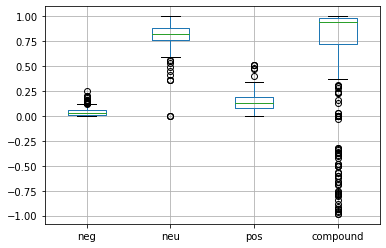

In [104]:
# Sentiment Analysis 4
print(saspam[['neg', 'neu', 'pos', 'compound']].mean())
saspam.boxplot(column=['neg', 'neu', 'pos', 'compound'])


neg         0.054228
neu         0.861504
pos         0.084264
compound    0.320380
dtype: float64


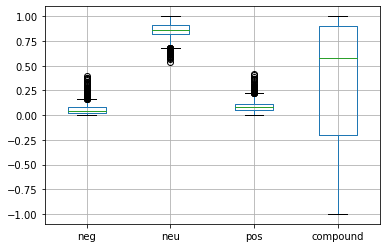

In [105]:
# Sentiment Analysis 5
print(saham[['neg', 'neu', 'pos', 'compound']].mean())
saham.boxplot(column=['neg', 'neu', 'pos', 'compound'])

## Bigram Analysis
This code looks at the bigram frequency in the content of the training emails. I found that this was somewhat intensive and chose to include the time it would take for execution.

In [106]:
%%timeit
bigram_measures = nltk.collocations.BigramAssocMeasures()

trainContentText = ""
for index, row in train[train['class'] == 'spam'].iterrows():
  trainContentText = trainContentText + row['Content']

tokens = quickTokenizer(trainContentText)
finder = BigramCollocationFinder.from_words(tokens)


1 loop, best of 5: 7.02 s per loop


Here is a snippet of the bigrams found.

In [113]:
finder.apply_freq_filter(3)
scored = finder.score_ngrams(bigram_measures.raw_freq)
sorted(bigram for bigram, score in scored)
finder.nbest(bigram_measures.pmi, 10)

[('achy', 'breaky'),
 ('adobe', 'photoshop'),
 ('bangles', 'flinstones'),
 ('batman', 'danny'),
 ('beckley', 'cupertino'),
 ('cockle', 'doodle'),
 ('converts', 'isilo'),
 ('cyber', 'firepower'),
 ('dakika', 'sanki'),
 ('dann', 'trage')]

This code creates the features to count the spam bigrams in the text. 

In [114]:
top100spambigrams = finder.nbest(bigram_measures.pmi, 100)

# Returns FreqDist [k, v]: (tuple, int)
def freqBigrams(text):
  temp = sanitizeText(text)
  token = nltk.word_tokenize(temp)
  if len(token) == 0:
    token = ['NA']
  bigram = list(nltk.ngrams(token, 2)) 
  fdist = nltk.FreqDist(bigram)
  return fdist

# top100spambigrams and function freqBigrams are required
def countSpamBigrams(text):
  count = 0
  f1 = freqBigrams(text)
  for k, v in f1:
    if k in top100spambigrams:
      count = count + v
  return count


# NLTK Model
After several iterations, the final features that I settled upon to construct the classifier were:
* Domain of the From Email
* Number of Misspellings in the Content
* Number of High Frequency Spam Words in the Subject
* Count of the High Frequency Spam Bigrams in the Content

In [119]:
%%timeit
# Modified Feature Set to use last letter
trainsets = []
for index, row in train.iterrows():
  temp = domain(row['From'])
  temp['misspelled'] = misspellings(row['Subject'])
  temp['contentmisspells'] = misspellings(row['Content'])
  temp['spamWords'] = countSpamSubjectWords(row['Subject'])
  temp['subject'] = sanitizeText(row['Subject'])
  temp['content'] = sanitizeText(row['Content'])
  temp['countbigrams'] = countSpamBigrams(row['Content'])
  x = ( temp, row['class'] )
  trainsets.append(x)

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(trainsets)

# Top 10 Informative Features
classifier.show_most_informative_features(10)

Most Informative Features
               spamWords = 3                spam : ham    =     57.6 : 1.0
              domainname = 'spamassassin.taint.org'    ham : spam   =     38.1 : 1.0
              domainname = 'canada.com'      ham : spam   =     23.5 : 1.0
               spamWords = 2                spam : ham    =     14.6 : 1.0
              domainname = 'yahoo.com'      spam : ham    =     12.8 : 1.0
              domainname = 'linux.ie'        ham : spam   =     11.7 : 1.0
        contentmisspells = 39               spam : ham    =      8.1 : 1.0
              domainname = 'earthlink.net'   spam : ham    =      7.1 : 1.0
              domainname = 'netnoteinc.com'   spam : ham    =      6.8 : 1.0
        contentmisspells = 116              spam : ham    =      6.4 : 1.0
Most Informative Features
               spamWords = 3                spam : ham    =     57.6 : 1.0
              domainname = 'spamassassin.taint.org'    ham : spam   =     38.1 : 1.0
              domainname 

In [121]:
%%timeit
# Run the classifier with the dev_test set
testsets = []
for index, row in test.iterrows():
  temp = domain(row['From'])
  temp['misspelled'] = misspellings(row['Subject'])
  temp['contentmisspells'] = misspellings(row['Content'])
  temp['spamWords'] = countSpamSubjectWords(row['Subject'])
  temp['subject'] = sanitizeText(row['Subject'])
  temp['content'] = sanitizeText(row['Content'])
  temp['countbigrams'] = countSpamBigrams(row['Content'])

  x = ( temp, row['class'] )
  testsets.append(x)

# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, testsets))

0.9454545454545454
0.9454545454545454
0.9454545454545454
0.9454545454545454
0.9454545454545454
0.9454545454545454
1 loop, best of 5: 4.97 s per loop


# Scikit Learn
After working with the classifier and identifying the best features, the best accuracy I could attain was 0.95. This was with additional time needed for computation. I decided to experiment using the `Scikit` library. I found a great tutorial at https://www.youtube.com/watch?v=cNLPt02RwF0 


This code sets up for `sklearn` using the `MultinomialNB`. Additional information can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

In [126]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def process_text(text):
  nopunc = [char for char in text if char not in string.punctuation]
  nopunc = ''.join(nopunc)

  words = [word for word in nopunc.split() if word.lower() not in stop_words]

  return words

bagofWords = CountVectorizer(analyzer=process_text).fit_transform(data['Content'])

Splits the data.

In [127]:
X_train, X_test, y_train, y_test = train_test_split(bagofWords, data['class'], test_size=0.2, random_state=42)


Creates the model. Observe how quick the runtime is.

In [134]:
%%timeit
# Create the classifier
classifier = MultinomialNB().fit(X_train, y_train)

10 loops, best of 5: 33.4 ms per loop


In [135]:
# Example of using the classifier
print(classifier.predict(X_train))
print(y_train.values)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']
['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [136]:
# Examines the accuracy of the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [137]:
# Runs the test data and prints a confusion matrix

predictions = classifier.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[801   5]
 [ 16 388]]
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       806
        spam       0.99      0.96      0.97       404

    accuracy                           0.98      1210
   macro avg       0.98      0.98      0.98      1210
weighted avg       0.98      0.98      0.98      1210



The model using scikit was quick and provided greater accuracy than the model built from the NLTK.

In [138]:
# The accuracy of the test data
accuracy_score(y_test, predictions)

0.9826446280991735

# Conclusion
Using the feature sets is helpful with NLTK. However, for runtime, `scikit` was blazingly fast for bag of words analysis.

For an efficient spam filter, the model has to be constantly fed updated data. 

# Additional Links

These were helpful links:
* Paul Graham's Site: http://paulgraham.com/spam.html
* Wikipedia's Site for NB: https://en.wikipedia.org/wiki/Naive_Bayes_classifier
* Additional Wiki site: https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering